In [1]:
print("hello, world")

hello, world


In [ ]:
# Use QiskitRuntimeService from qiskit-ibm-runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from os import getenv
# Get IBM Quantum account from environment variable
ibmq_token = getenv("ibmq_token")
QiskitRuntimeService.save_account(token=ibmq_token, channel='ibm_quantum', overwrite=True)

ModuleNotFoundError: No module named 'qiskit_ibm_runtime'

In [4]:
print(f"IBM Quantum token: {ibmq_token}")

IBM Quantum token: 454f22e1ac9e277ccc4f7478374051569e83ad162327fe3a51cce3e1e7b74c1b5b3233a8a7c6bd304c73ee5a37c02580043ee912eb024e8aa6ae8c7d37f25912


In [5]:
if ibmq_token is None:
    raise ValueError("IBM Quantum Token not found in environment variables. Please set it.")

# Print part of the token to verify
print(f"Retrieved IBM Quantum Token: {ibmq_token[:10]}...")

# Instantiate the QiskitRuntimeService
try:
    # Initialize service with token. Specify channel if needed (e.g., 'ibm_cloud', 'ibm_quantum').
    service = QiskitRuntimeService(token=ibmq_token, channel='ibm_quantum')
    print("QiskitRuntimeService initialized successfully.")
except Exception as e:
    print(f"Failed to initialize QiskitRuntimeService: {e}")
    raise

Retrieved IBM Quantum Token: 454f22e1ac...
QiskitRuntimeService initialized successfully.


In [6]:
available_backends = service.backends()
show_backend = print(available_backends)
choose = input("Enter the name of the backend you want to choose : ")

backend = next((backend for backend in available_backends if str(backend) == choose), None)
if backend is None:
    print("No backend found with the name:", choose)

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]


In [7]:
if backend is not None and backend.configuration().simulator is False:
    print(f"Successfully connected to the selected QPU backend: {backend}")
else:
    print("Failed to connect to the selected QPU backend or the backend is a simulator.")

Successfully connected to the selected QPU backend: <IBMBackend('ibm_kyiv')>


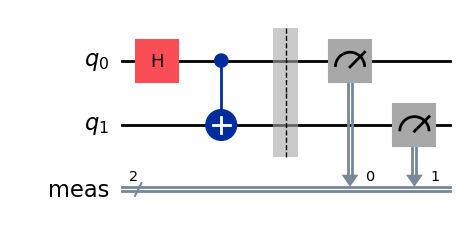

In [8]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0) # Add a Hadamard gate to qubit 0
qc.cx(0, 1) # Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.measure_all() # Measure all qubits

''' Return a drawing of the circuit using MatPlotLib ("mpl"). This is the last line of the cell, 
so the drawing appears in the cell output. Remove the "mpl" argument to get a text drawing. '''
qc.draw('mpl')

In [9]:
# import the required libraries
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

In [10]:
# Set up six different observables.
observables_labels = ["ZZ", "ZI", "IZ", "XX", "XI"]
observables = [SparsePauliOp(label) for label in observables_labels]

In [11]:
service = QiskitRuntimeService('ibm_quantum')

In [12]:
# construct the estimator instance we want to use
estimator = Estimator(backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
 

In [13]:
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
observables = [observable.apply_layout(isa_circuit.layout) for observable in observables]

In [14]:
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, observables)])
 
# This is the result of the entire submission.  We submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]

<ErrorbarContainer object of 3 artists>

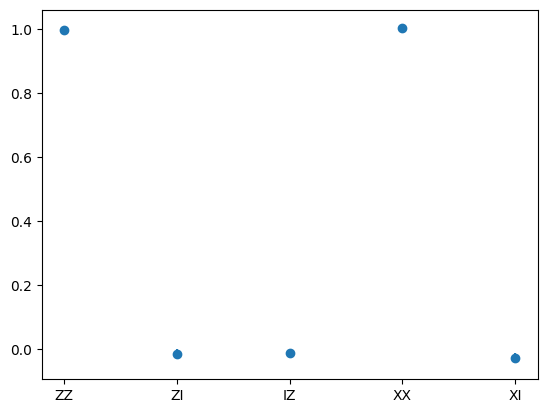

In [15]:
# Plot the result
 
from matplotlib import pyplot as plt
 
data = observables_labels
values = pub_result.data.evs
 
errors = pub_result.data.ensemble_standard_error
 
plt.errorbar(observables_labels, values, yerr=errors, fmt="o")

In [16]:
job11 = service.job('czrdddnd8drg008gq210')
job_result = job11.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: [ 0.99649573 -0.01547304 -0.01408268  1.00308141 -0.02850297]
